<a href="https://colab.research.google.com/github/EvelynChrisyla/Data-Analytics-Visualization/blob/main/Data_Visualization_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark
from pyspark.sql.functions import*
from pyspark.sql import SparkSession
spark= SparkSession.builder.getOrCreate()

In [2]:
# READ DATA
ramen_table = spark.read.option("inferSchema", "true").csv("MsRamen.csv", header = True)
customer_table = spark.read.option("inferSchema", "true").csv("MsCustomer.csv", header = True)
country_table= spark.read.option("inferSchema", "true").csv("MsCountry.csv", header = True)
brand_table= spark.read.option("inferSchema", "true").csv("MsBrand.csv", header = True)
ramenstyle_table = spark.read.option("inferSchema", "true").csv("MsRamenStyle.csv", header = True)
Transactionheader_table= spark.read.option("inferSchema", "true").csv("TransactionHeader.csv", header = True)
Transactiondetail_table= spark.read.option("inferSchema", "true").csv("TransactionDetail.csv", header = True)

In [3]:
#convert the table into a table that can be read by Spark. because this table is still a dataframe
ramen_table.registerTempTable("MsRamen") #name the table
customer_table.registerTempTable("MsCustomer")
country_table.registerTempTable("MsCountry")
ramenstyle_table.registerTempTable("MsRamenStyle")
brand_table.registerTempTable("MsBrand")
Transactionheader_table.registerTempTable("TransactionHeader")
Transactiondetail_table.registerTempTable("TransactionDetail")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [4]:
import matplotlib.pyplot as plt

# **1. Show Top 5 Customer with the most transaction for customer with indonesian phone Number using pie chart.**

In [21]:
TotalTransaction = spark.sql("""
  SELECT CustomerName,
    COUNT(TransactionID) AS TotalTransaction
  FROM MsCustomer c
  JOIN TransactionHeader th
  ON c.CustomerID = th.CustomerID
  WHERE CustomerPhone LIKE "+62%"
  GROUP BY CustomerName
  ORDER BY TotalTransaction DESC
  LIMIT 5
""")
TotalTransaction.show()

+-----------------+----------------+
|     CustomerName|TotalTransaction|
+-----------------+----------------+
|      Matt Towhey|               9|
|Roderigo Sjostrom|               9|
|  Nananne Celloni|               9|
|          Lon Rex|               9|
|   Darb Ivanyutin|               8|
+-----------------+----------------+



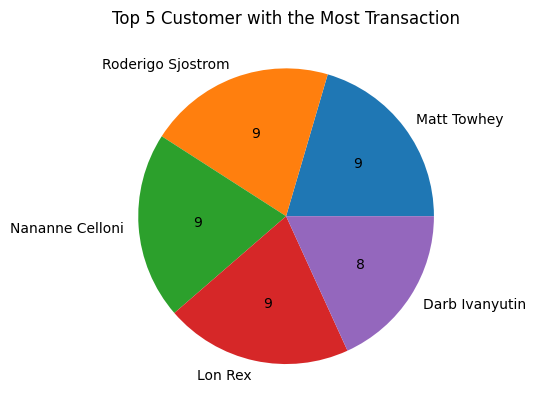

In [26]:
df_TotalTransaction = TotalTransaction.toPandas()

#Make Pie Chart
plt.pie (df_TotalTransaction["TotalTransaction"], labels= df_TotalTransaction["CustomerName"],autopct=lambda p: '{:.0f}'.format(p *df_TotalTransaction["TotalTransaction"].sum() / 100))
plt.title('Top 5 Customer with the Most Transaction')
plt.show()

# **2. Show the Year income of RamenShop Data that above average using line chart**

In [18]:
calculation= spark.sql("""
  SELECT YEAR(th.TransactionDate) AS YEAR,
    SUM(td.Quantity*r.RamenPrice) AS INCOME
  FROM TransactionHeader th
  JOIN TransactionDetail td
  ON th.TransactionID = td.TransactionID
  JOIN MsRamen r
  ON td.RamenID = r.RamenID
  GROUP BY YEAR
  HAVING INCOME > (SELECT AVG(r.RamenPrice * td.Quantity) FROM TransactionHeader th
                                                                JOIN TransactionDetail td
                                                                ON th.TransactionID = td.TransactionID
                                                                JOIN MsRamen AS r
                                                                ON td.RamenID = r.RamenID)

""")
calculation.show()

# Put it in pandas
result = calculation.toPandas()

+----+----------+
|YEAR|    INCOME|
+----+----------+
|2019|3732463000|
+----+----------+



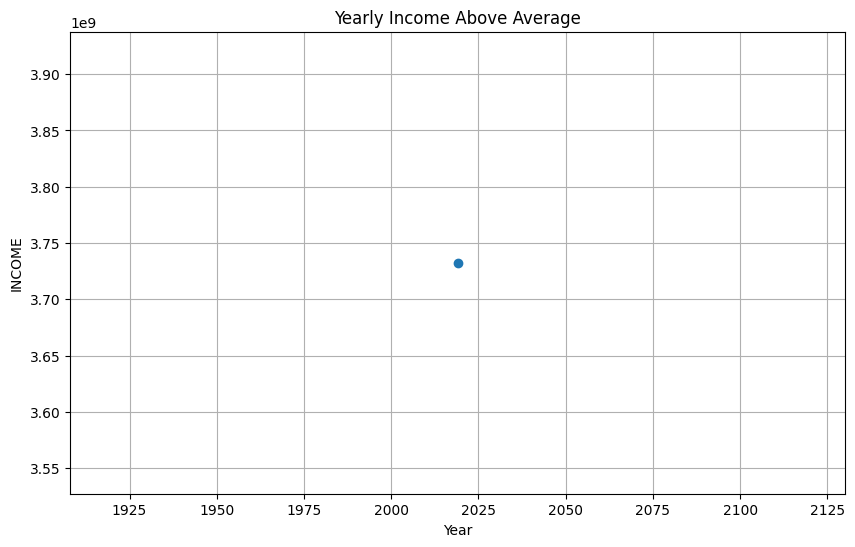

In [19]:

plt.figure(figsize=(10, 6))
plt.plot(result['YEAR'], result['INCOME'], marker='o', linestyle='-')
plt.title('Yearly Income Above Average')
plt.xlabel('Year')
plt.ylabel('INCOME')
plt.grid(True)
plt.show()

This is because the sales data is all in 2019

# **3. Show the frequency of customer spending category in RamenShop. Each customer Spending Category is determined by below condition:**

Using Bar Chart


```
    Total Spend            MemberShip
      <100K                   Low
     100-1M                   Mid
       1M                     Mega
```



In [7]:
Category = spark.sql("""
SELECT
  CustomerName,
  CASE
    WHEN SUM(Quantity*RamenPrice)<100000 THEN "Low"
    WHEN SUM(Quantity*RamenPrice) >1000000 THEN "Mega"
    ELSE "Mid"
  END AS Category
FROM MsCustomer c
JOIN TransactionHeader th
ON c.CustomerID = th.CustomerID
JOIN TransactionDetail td
ON th.TransactionID = td.TransactionID
JOIN MsRamen r
ON td.RamenID = r.RamenID
GROUP BY CustomerName
""")
Category.show()

+----------------+--------+
|    CustomerName|Category|
+----------------+--------+
|Lorene MacParlan|    Mega|
|   Jacobo Zemler|    Mega|
|   Arney Dunkley|    Mega|
|  Rhona Sutterby|    Mega|
|     Marve Dagon|    Mega|
|  Marilin Balfre|    Mega|
| Salomi Georgins|    Mega|
|  Clint Faulkner|    Mega|
| Kaitlyn McKaile|    Mega|
|    Stan Twydell|     Mid|
|   Willey Mepham|    Mega|
| Gabbey Silcocks|    Mega|
|    Debee Kenson|    Mega|
|Ellette Gonsalvo|    Mega|
|     Rhett Marco|    Mega|
| Windham Houlson|     Mid|
|     Lenci Brace|     Mid|
| Kingsly Dabling|    Mega|
| Aila Tomaszczyk|     Mid|
| Rudolph Tetther|    Mega|
+----------------+--------+
only showing top 20 rows



In [8]:
# Conversion Query Result to Pandas
df_Category = Category.toPandas()

# Calculate frequency each category (Low, Mid, Mega)
category_counts = df_Category['Category'].value_counts()
category_counts

Mega    1684
Mid     1158
Low       49
Name: Category, dtype: int64

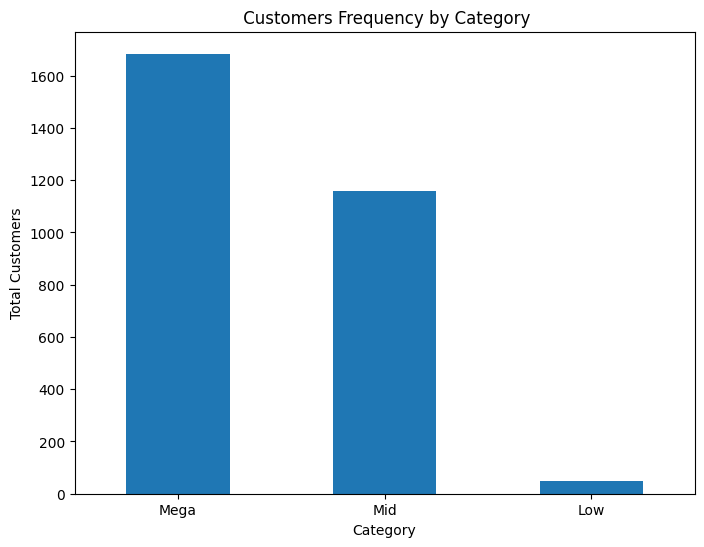

In [9]:
#Make Bar Chart
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')
plt.title(' Customers Frequency by Category')
plt.xlabel('Category')
plt.ylabel('Total Customers')
plt.xticks(rotation=0)
plt.show()

# **4. Show Top 5 Brand with the most transaction for customer with indonesian phone Number using pie chart.**

In [10]:
TopBrand = spark.sql("""
  SELECT BrandName,
  COUNT(td.RamenID) AS TotalTransaction
  FROM MsCustomer c
  JOIN TransactionHeader th
  ON c.CustomerID = th.CustomerID
  JOIN TransactionDetail td
  ON th.TransactionID =td.TransactionID
  JOIN MsRamen r
  ON td.RamenID = r.RamenID
  JOIN MsBrand b
  ON r.BrandID = b.BrandID
  WHERE CustomerPhone LIKE "+62%"
  GROUP BY BrandName
  ORDER BY TotalTransaction DESC
  LIMIT 5
""")
TopBrand.show()

+---------+----------------+
|BrandName|TotalTransaction|
+---------+----------------+
|   Nissin|             376|
| Nongshim|             101|
|    Paldo|              87|
| Maruchan|              85|
|     Mama|              75|
+---------+----------------+



In [11]:
Df_TopBrand = TopBrand.toPandas()

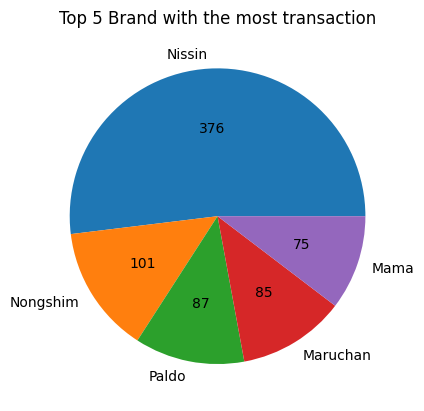

In [24]:

plt.pie(
    Df_TopBrand["TotalTransaction"],
    labels=Df_TopBrand["BrandName"],
    autopct=lambda p: '{:.0f}'.format(p * Df_TopBrand["TotalTransaction"].sum() / 100)
)

plt.title('Top 5 Brand with the most transaction')
plt.show()

# **5.	Show the amount of revenue for each month within year 2019 using line plot.**

In [13]:
Revenue= spark.sql("""
  SELECT
    MONTH(TransactionDate) AS Month,
    SUM(RamenPrice*Quantity) AS Total
  FROM TransactionHeader th
  JOIN TransactionDetail td
  ON th.TransactionID = td.transactionID
  JOIN MsRamen r
  ON td.RamenID = r.RamenID
  GROUP BY Month
  ORDER BY Month
""")
Revenue.show()

+-----+---------+
|Month|    Total|
+-----+---------+
|    1|316534000|
|    2|292087000|
|    3|328064000|
|    4|302013000|
|    5|305102000|
|    6|310177000|
|    7|312101000|
|    8|328337000|
|    9|307199000|
|   10|317046000|
|   11|317946000|
|   12|295857000|
+-----+---------+



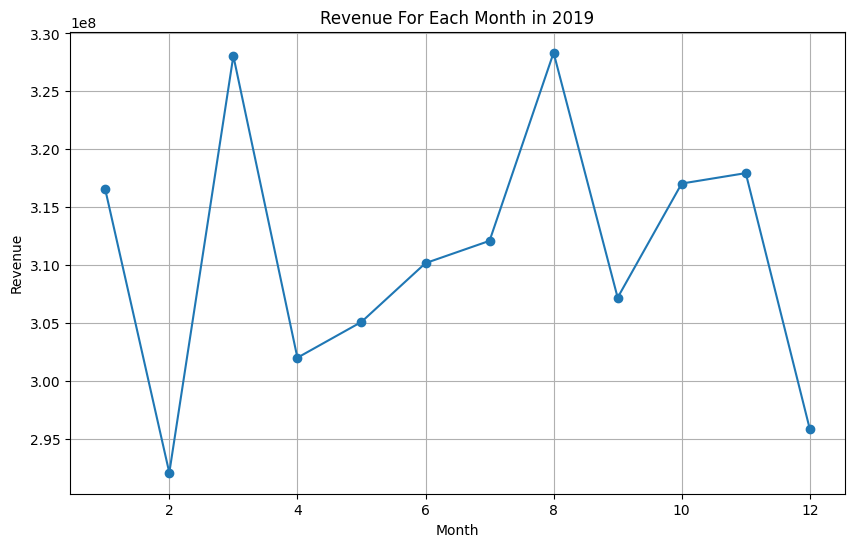

In [14]:
df_Revenue= Revenue.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(df_Revenue['Month'], df_Revenue['Total'], marker='o', linestyle='-')
plt.title('Revenue For Each Month in 2019')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

# **6.	Show top 5 ramen style that is used in making the ramen using bar plot**

In [15]:
TopRamenStyle = spark.sql("""
  SELECT RamenStyleName,
  COUNT(td.RamenID) AS TotalSold
  FROM TransactionDetail td
  JOIN MsRamen r
  ON td.RamenID = r.RamenID
  JOIN MsRamenStyle rs
  ON r.RamenStyleID = rs.RamenStyleID
  GROUP BY RamenStyleName
  ORDER BY TotalSold DESC
  LIMIT 5
""")
TopRamenStyle.show()


+--------------+---------+
|RamenStyleName|TotalSold|
+--------------+---------+
|          Pack|    14887|
|          Bowl|     4672|
|           Cup|     4236|
|          Tray|     1137|
|           Box|       54|
+--------------+---------+



In [16]:
df_TopRamenStyle = TopRamenStyle.toPandas()

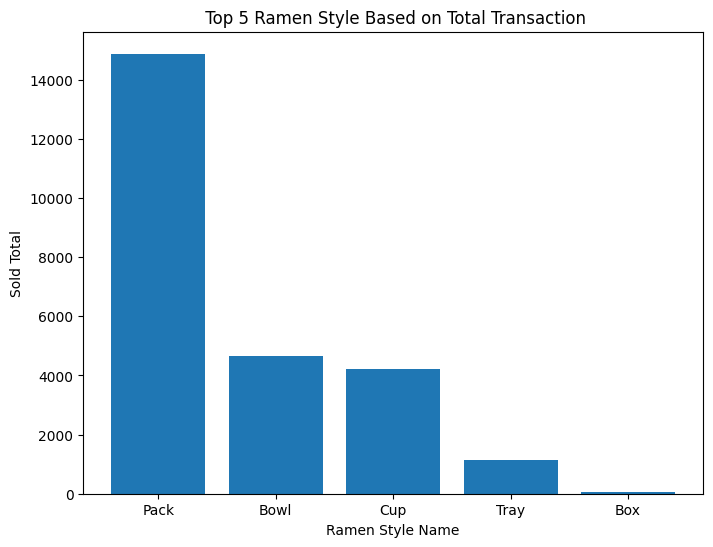

In [17]:
#Make Bar Chart
plt.figure(figsize=(8, 6))
plt.bar(df_TopRamenStyle['RamenStyleName'], df_TopRamenStyle['TotalSold'])
plt.title(' Top 5 Ramen Style Based on Total Transaction')
plt.xlabel('Ramen Style Name')
plt.ylabel('Sold Total')
plt.xticks(rotation=0)
plt.show()